In [1]:
# imports
import ROOT
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('/exp/icarus/app/users/lkashur/medulla/medulla/spineplot/styles/pi0ana.mplstyle')
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.stats import norm, bootstrap
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
#from concurrent.futures import ThreadPoolExecutor
import gc

## Helper functions

In [2]:
def transform_as(cov, param):
    """
    Apply a scale correction to the covariance matrix. This is
    intended to be used when the covariance matrix is meant to be
    rescaled to a different exposure, or for the case where the
    spectrum is being area normalized. The former case is realized
    by a "simple" scale correction (i.e. the covariance matrix is
    multiplied by the square of the scale). The latter case is
    realized by a "normalized" scale correction (i.e. the
    covariance matrix is properly transformed to account for how
    the area normalization impacts the covariance matrix).

    Parameters
    ----------
    cov : numpy.ndarray
        The covariance matrix to transform.
    param : float or np.ndarray
        The parameter to use for the transformation. For a "simple"
        scale correction, this is a float. For a "normalized" scale
        correction, this is a numpy array with the same shape as
        `cov` and containing the bin contents of the histogram.
    
    Returns
    -------
    numpy.ndarray
        The transformed covariance matrix.
    """
    if np.isscalar(param):
        return cov * param**2

    else:
        A = np.sum(param)
        y = param.reshape(-1, 1)
        delta = np.eye(len(y))
        jacobian = (delta * A - y) / A**2
        return jacobian @ cov @ jacobian.T

def draw_error_boxes(ax, x, y, xerr, yerr, **kwargs):
    """
    Adds error boxes to the input axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to which the error boxes are to be added.
    x : numpy.array
        The x-coordinates of the error boxes.
    y : numpy.array
        The y-coordinates of the error boxes.
    xerr : numpy.array
        The x-error values of the error boxes.
    yerr : numpy.array
        The y-error values of the error boxes.
    kwargs: dict
        Keyword arguments to be passed to the errorbar function.

    Returns
    -------
    None.
    """
    boxes = [Rectangle((x[i] - xerr[i], y[i] - yerr[i]), 2 * np.abs(xerr[i]), 2 * yerr[i]) for i in range(len(x)) if y[i] > 0]
    pc = PatchCollection(boxes, **kwargs)
    ax.add_collection(pc)

def add_plot_labels(ax, pot, vadj=0.025, ana_status=str(), title=str()):
    xrange = ax.get_xlim() 
    yrange = ax.get_ylim()                                                                                                                     

    usex = xrange[0]
    usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
    #s = r'$\bf{ICARUS}$ Work-in-Progress'
    ax.text(x=usex, y=usey, s=ana_status, fontsize=13, color='#d67a11')   
    
    usex = xrange[1]
    usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
    mag = int(np.floor(np.log10(pot)))
    usepot = pot/10**mag
    s = f'{usepot:.2f}'+f'$\\times 10^{{{mag}}}$ POT'
    ax.text(x=usex, y=usey, s=s, fontsize=13, color='black', horizontalalignment='right')

def ndarray_to_tmatrixtsym(np_array):
    size = np_array.shape[0]
    tmatrix = ROOT.TMatrixDSym(size)

    for i in range(size):
        for j in range(i, size):
            tmatrix[i][j] = np_array[i, j]
            tmatrix[j][i] = np_array[i, j]
    return tmatrix


def process_col_cov_mats(col_vals):
    universe_weights = np.stack(col_vals.to_numpy())
    histogram = np.zeros((len(bin_edges) - 1, universe_weights.shape[1]))
    filtered_weights = universe_weights[cv_valid_indices, :]
    np.add.at(histogram, cv_bin_indices, filtered_weights)

    diff = histogram - cv_histogram[:, np.newaxis]
    cov_mat = (diff @ diff.T) / (universe_weights.shape[1])   
    return cov_mat

def process_col_cov_stds(col_vals):
    universe_weights = np.stack(col_vals.to_numpy())
    histogram = np.zeros((len(bin_edges) - 1, universe_weights.shape[1]))
    filtered_weights = universe_weights[cv_valid_indices, :]
    np.add.at(histogram, cv_bin_indices, filtered_weights)

    diff = histogram - cv_histogram[:, np.newaxis]  
    diff = np.sum(diff, axis=0)
    std = np.sqrt((diff @ diff.T) / (universe_weights.shape[1]))
    std /= universe_weights.shape[0]
    return std

def double_sided_crystal_ball(x, mu, sigma, alpha_L, alpha_R, n_L, n_R, N):
    """
    Double-sided Crystal Ball function.

    Parameters:
    - x: Input data points.
    - mu: Mean of the Gaussian core.
    - sigma: Standard deviation of the Gaussian core.
    - alpha_L: Transition point for the left power-law tail.
    - n_L: Exponent of the left power-law tail.
    - alpha_R: Transition point for the right power-law tail.
    - n_R: Exponent of the right power-law tail.
    - N: Normalization constant.
    """
    t = (x - mu) / sigma
    result = np.zeros_like(x, dtype=float)

    # Gaussian core
    mask_gaussian = (-alpha_L <= t) & (t <= alpha_R)
    result[mask_gaussian] = np.exp(-0.5 * t[mask_gaussian]**2)

    # Left power-law tail
    mask_left_tail = (t < -alpha_L)
    A_L = (n_L / alpha_L)**n_L * np.exp(-0.5 * alpha_L**2)
    B_L = n_L / alpha_L - alpha_L
    result[mask_left_tail] = A_L * (B_L - t[mask_left_tail])**(-n_L)

    # Right power-law tail
    mask_right_tail = (t > alpha_R)
    A_R = (n_R / alpha_R)**n_R * np.exp(-0.5 * alpha_R**2)
    B_R = n_R / alpha_R - alpha_R
    result[mask_right_tail] = A_R * (B_R + t[mask_right_tail])**(-n_R)

    return N * result

def exponential_decay(x, A, K, C):
    return A * np.exp(-K * x) + C

## Choice of analyis variable
i.e. neutral pion mass

In [3]:
_vars = ["reco_pi0_mass"]
#bin_edges = np.linspace(0, 400, 41)
bin_edges = np.linspace(0, 600, 61)
#bin_edges = np.linspace(60, 300, 25)
xlabel = "Reconstructed $\\pi^{0}$ Mass [MeV/c$^{2}$]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
#fit = {"type" : "double_sided_crystal_ball", "start_index" : 0, "end_index" : -1}
#figsize = (16,8)
figsize = (10,8)
#_var_ylim = None
_var_ylim = [0,0.375]

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)

## Histogram configuration

In [4]:
##############################################
### Signal and background categories
##############################################
category_branch = 'true_category_topology_ccpi0_simple2'
#category_assignment = [[0], [1], [2], [3], [4], [-1,10], [-100]]
category_labels = ['1$\\mu$0$\\pi^{±}$1$\\pi^{0}$', '1$\\mu$0$\\pi^{±}$ (2+ $\\pi^{0}$)', '1$\\mu$N$\\pi^{±}$X$\\pi^{0}$', 'NC N$\\pi^{0}$', 'Other $\\nu$', 'Cosmic', 'Run 2 Data']
category_colors = ['C0', 'C5', 'C6', 'C1', 'C3', 'C4', 'black']
category_types = ['histogram', 'histogram', 'histogram', 'histogram', 'histogram', 'histogram', 'scatter']

##############################################
### Plotting options
##############################################
normalize = True
if normalize == True:
    show_component_number = False
    ylabel = 'Normalized Candidates'
else:
    show_component_number = True
    ylabel = 'Candidates'

show_data = True

In [5]:
assess_systematics = False

# flux systematics
params_multisim_flux = [
    'expskin_Flux',
    'horncurrent_Flux',
    'nucleoninexsec_Flux',
    'nucleonqexsec_Flux',
    'nucleontotxsec_Flux',
    'pioninexsec_Flux',
    'pionqexsec_Flux',
    'piontotxsec_Flux',
    'piplus_Flux',
    'piminus_Flux',
    'kplus_Flux',
    'kminus_Flux',
    'kzero_Flux'
]

# cross section systematics (multisim)
params_multisim_xsec = [
    #'GENIEReWeight_SBN_v1_multisim_COHVariationResponse',
]

# cross section systematics (multisigma)
params_multisigma_xsec = [
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b1',
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b2',
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b3',
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b4',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_RPA_CCQE',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_CoulombCCQE',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NormCCMEC',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MaCCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MvCCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MaNCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MvNCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_AhtBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_BhtBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_CV1uBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_CV2uBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MaNCEL',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_EtaNCEL',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MFP_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrCEx_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrInel_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrAbs_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrPiProd_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MFP_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrCEx_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrInel_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrAbs_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrPiProd_N',
]

# detector systematics
params_detsys = [
    'cov_weights_var01',
    'cov_weights_var04',
    'cov_weights_var05',
    'cov_weights_var06',
    'cov_weights_var07',
    'cov_weights_var10',
    'cov_weights_var11',
    'cov_weights_var12',
    'cov_weights_var13',
    'cov_weights_var99'
]

params_multisim = params_multisim_flux + params_multisim_xsec
params_multisigma = params_multisigma_xsec + params_detsys

# test
#params_multisim = []
#params_multisigma = params_detsys

## Gather inputs

In [6]:
# no pi0 mass cut + mystery pi0 z gap cut and calosyst and pi0 momentum detsyst and numu == 14
event_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_24_nov_2025/apply_pi0_mass_adj/icarus_bnb_ccpi0_cvfull_offbeam_onbeam.root")

# samples
sample_scalings = []
sample_dfs = []

# sim
sim_pot = event_file['events/cvfull/POT'].to_numpy()[0][0]
#sim_pot = 1.675278148079016e+21
selected_nu_tree = event_file['events/cvfull/selected_nu']
selected_nu_df = selected_nu_tree.arrays(_vars + [category_branch], library='pd')
selected_cos_tree = event_file['events/cvfull/selected_cos']
selected_cos_df = selected_cos_tree.arrays(_vars + [category_branch], library='pd')

# offbeam
offbeam_livetime = event_file['events/offbeam/Livetime'].to_numpy()[0][0]
selected_offbeam_tree = event_file['events/offbeam/selected_cos']
selected_offbeam_df = selected_offbeam_tree.arrays(_vars + [category_branch], library='pd')
selected_offbeam_df[category_branch] = [-1]*len(selected_offbeam_df)

# onbeam
#onbeam_pot = syst_file['events/onbeam/POT'].to_numpy()[0][0]
onbeam_pot = 1.6193e+19
#onbeam_livetime = event_file['events/onbeam/Livetime'].to_numpy()[0][0]
onbeam_livetime = 4069800.0
selected_onbeam_tree = event_file['events/onbeam/selected_nu']
selected_onbeam_df = selected_onbeam_tree.arrays(_vars + [category_branch], library='pd')
selected_onbeam_df[category_branch] = [-100]*len(selected_onbeam_df)

sample_scalings = [
    onbeam_pot/sim_pot,
    onbeam_pot/sim_pot,
    onbeam_livetime/offbeam_livetime,
    1
]

sample_dfs = [
    selected_nu_df,
    selected_cos_df,
    selected_offbeam_df,
    selected_onbeam_df
]

# systematics
if assess_systematics:
    multisim_tree = event_file['events/cvfull/selected_nu_multisimTree']
    multisim_df = multisim_tree.arrays(params_multisim, library='pd')
    multisigma_tree = multisigma_syst_file['selected']
    multisigma_df = multisigma_tree.arrays(params_multisigma, library='pd')

    del multisim_tree
    del multisigma_tree
    gc.collect()
    syst_df = pd.concat([multisim_df, multisigma_df], axis=1)
    del multisim_df
    del multisigma_df
    gc.collect()

## Attach sample weights for scaling

In [7]:
for w,df in zip(sample_scalings, sample_dfs):
    df['sample_weight'] = [w] * len(df)

## Calculate covariance matrices from universe weights

In [8]:
# Prepare CV histogram
cv_data = selected_nu_df[_vars[0]].to_numpy()
cv_bin_indices = np.digitize(cv_data, bin_edges) - 1
cv_valid_indices = (cv_bin_indices >= 0) & (cv_bin_indices < len(bin_edges) - 1)
cv_bin_indices = cv_bin_indices[cv_valid_indices]
cv_histogram = np.zeros(len(bin_edges) - 1)
np.add.at(cv_histogram, cv_bin_indices, 1)

# norm for fractional covariance
#cv_norm = np.outer(cv_histogram, cv_histogram)

# Prepare offbeam histogram (needed for overall statistical uncertainty)
offbeam_data = selected_offbeam_df[_vars[0]].to_numpy()
offbeam_bin_indices = np.digitize(offbeam_data, bin_edges) - 1
offbeam_valid_indices = (offbeam_bin_indices >= 0) & (offbeam_bin_indices < len(bin_edges) - 1)
offbeam_bin_indices = offbeam_bin_indices[offbeam_valid_indices]
offbeam_histogram = np.zeros(len(bin_edges) - 1)
np.add.at(offbeam_histogram, offbeam_bin_indices, 1)

In [9]:
# Storage
cov_mats_params = {}
#frac_cov_mats_params = {}
cov_stds_params = {}

In [10]:
# Loop over all systematic parameters
if assess_systematics:

    # Loop over each parameter
    for col, vals in syst_df.items():
        
        universe_weights = np.stack(vals.to_numpy())
        histogram = np.zeros((len(bin_edges) - 1, universe_weights.shape[1]))
        filtered_weights = universe_weights[cv_valid_indices, :]
        np.add.at(histogram, cv_bin_indices, filtered_weights)
    
        diff = histogram - cv_histogram[:, np.newaxis]
        cov_mat = (diff @ diff.T) / (universe_weights.shape[1])
        cov_mats_params[col] = cov_mat
        #frac_cov_mats_params[col] = np.divide(cov_mats_params[col], cv_norm, where=cv_norm!=0)
    
        diff = np.sum(diff, axis=0)
        std = np.sqrt((diff @ diff.T) / (universe_weights.shape[1]))
        std /= universe_weights.shape[0]
        cov_stds_params[col] = std  

In [11]:
# statistical uncertainty
cov_mats_params['sim_stat'] = np.diag(cv_histogram)
std = np.sqrt(cv_histogram.sum())
std /= cv_histogram.sum()
cov_stds_params['sim_stat'] = std

cov_mats_params['offbeam_stat'] = np.diag(offbeam_histogram)
std = np.sqrt(offbeam_histogram.sum())
std /= offbeam_histogram.sum()
cov_stds_params['offbeam_stat'] = std

In [12]:
# Scale covariance matrices
# ONLY RUN ONCE
weight = onbeam_pot/sim_pot
for k,v in cov_mats_params.items():
    v *= weight**2

#for k,v in frac_cov_mats_params.items():
#    v*= weight**2

## Plot preparation

In [13]:
# Prepare samples for plotting
d,w = {}, {}
plotdata = {}
onebincount = {}
# Loop over samples
for df in sample_dfs:

    for cat in np.unique(df[category_branch]):
        if np.isnan(cat): continue
        
        d[int(cat)] = df[df[category_branch] == cat][_vars[0]]
        w[int(cat)] = df[df[category_branch] == cat]['sample_weight']

for category, values in d.items():
    plotdata[category] = np.zeros(len(bin_centers))
    onebincount[category] = 0
    h = np.histogram(values, bins=bin_edges, weights=w[category])
    onebincount[category] += np.sum(w[category])
    plotdata[category] += h[0]


# Merge cosmics and offbeam
cosmic_counts = np.zeros(len(bin_centers))
for k,v in plotdata.items():
    if k in [-1,10]:
        cosmic_counts += v
if -1 in plotdata:
    del plotdata[-1]
#del plotdata[-1]
plotdata[10] = np.array(cosmic_counts)
labels, data = zip(*plotdata.items())

cosmic_count = 0
for k,v in onebincount.items():
    if k in [-1,10]:
        cosmic_count += v
if -1 in onebincount:
    del onebincount[-1]
#del onebincount[-1]
onebincount[10] = cosmic_count

In [14]:
histogram_mask = [li for li, label in enumerate(labels) if category_types[li] == 'histogram']
scatter_mask = [li for li, label in enumerate(labels) if category_types[li] == 'scatter']
reduce = lambda x : [x[i] for i in histogram_mask][::-1]


denominator = np.sum([onebincount[labels[i]] for i in histogram_mask])
counts = [x for x in onebincount.values()]

hlabel = lambda x : f'{np.sum(x):.1f}, {np.sum(x)/denominator:.1%}'
slabel = lambda x : f'{np.sum(x):.1f}'
labels = [f'{label} ({hlabel(d) if li in histogram_mask else slabel(d)})' for li, (label, d) in enumerate(zip(category_labels, counts))]
if not show_component_number:
    labels = [f'{label} ({np.sum(d)/denominator:.1%})' if li in histogram_mask else label for li, (label, d) in enumerate(zip(category_labels, counts))]

## Bootstrap

In [15]:
# Perform bootstrapping to assess fit uncertainties
n_bootstraps = 1000
sim_bootstrap_params = []
data_bootstrap_params = []
alpha = 0.317  # For 68.3% confidence interval
lower_percentile = (alpha / 2) * 100
upper_percentile = (1 - alpha / 2) * 100

### SIM ####
bottom = np.zeros(len(bin_centers))
for (d,l,c) in zip(reduce(data),reduce(labels),reduce(category_colors)):
    bottom+=d

# initial parameter guesses
mu = np.sum(bottom * bin_centers) / np.sum(bottom)
sigma = np.sqrt(np.sum(bottom * (bin_centers**2)) / np.sum(bottom))
alpha_l = 1.5
alpha_r = 1.5
n_l = 2.3
n_r = 2.3
N = max(bottom)  
initial_guess = [mu, sigma, alpha_l, alpha_r, n_l, n_r, N]

for _ in range(n_bootstraps):

    sim_boot_counts = np.random.poisson(bottom)
    try:
        # Fit the Gaussian to the resampled counts
        popt_bootstrap, _ = curve_fit(double_sided_crystal_ball, bin_centers[fit['start_index']:fit['end_index']], sim_boot_counts[fit['start_index']:fit['end_index']], p0=initial_guess)
        sim_bootstrap_params.append(popt_bootstrap)
    except RuntimeError:
        # Handle cases where curve_fit might fail for a resampled dataset
        continue
        
sim_bootstrap_params = np.array(sim_bootstrap_params)
sim_ci_lower = np.percentile(sim_bootstrap_params, lower_percentile, axis=0)
sim_ci_upper = np.percentile(sim_bootstrap_params, upper_percentile, axis=0)

print(f"Confidence Intervals (68%):")
for i, (lower, upper) in enumerate(zip(sim_ci_lower, sim_ci_upper)):
    print(f"  Parameter {i+1}: ({lower}, {upper})")    

### DATA ###
if(show_data):
    reduce = lambda x : [x[i] for i in scatter_mask]
    for i, label in enumerate(reduce(labels)):
        mu = np.sum(bottom * bin_centers) / np.sum(data[scatter_mask[i]])
        sigma = np.sqrt(np.sum(data[scatter_mask[i]] * (bin_centers**2)) / np.sum(data[scatter_mask[i]]))
        alpha_l = 1.5
        alpha_r = 1.5
        n_l = 2.3
        n_r = 2.3
        N = max(bottom)    
        initial_guess = [mu, sigma, alpha_l, alpha_r, n_l, n_r, N]       


        # continue coding here!!!    
        for _ in range(n_bootstraps):

            boot_counts = np.random.poisson(data[scatter_mask[i]])
                
            try:
                # Fit the Gaussian to the resampled counts
                popt_bootstrap, _ = curve_fit(double_sided_crystal_ball, bin_centers[fit['start_index']:fit['end_index']], boot_counts[fit['start_index']:fit['end_index']], p0=initial_guess)
                data_bootstrap_params.append(popt_bootstrap)
            except RuntimeError:
                # Handle cases where curve_fit might fail for a resampled dataset
                continue

        data_bootstrap_params = np.array(data_bootstrap_params)
        data_ci_lower = np.percentile(data_bootstrap_params, lower_percentile, axis=0)
        data_ci_upper = np.percentile(data_bootstrap_params, upper_percentile, axis=0)

        print(f"Confidence Intervals (68%):")
        for j, (lower, upper) in enumerate(zip(data_ci_lower, data_ci_upper)):
            print(f"  Parameter {j+1}: ({lower}, {upper})")    

/tmp/ipykernel_193184/2732004088.py:143: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / alpha_R)**n_R * np.exp(-0.5 * alpha_R**2)
/tmp/ipykernel_193184/2732004088.py:145: RuntimeWarning: invalid value encountered in power
  result[mask_right_tail] = A_R * (B_R + t[mask_right_tail])**(-n_R)
/tmp/ipykernel_193184/2732004088.py:137: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / alpha_L)**n_L * np.exp(-0.5 * alpha_L**2)
/tmp/ipykernel_193184/2732004088.py:139: RuntimeWarning: invalid value encountered in power
  result[mask_left_tail] = A_L * (B_L - t[mask_left_tail])**(-n_L)
/tmp/ipykernel_193184/2732004088.py:137: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / alpha_L)**n_L * np.exp(-0.5 * alpha_L**2)
/tmp/ipykernel_193184/2732004088.py:139: RuntimeWarning: invalid value encountered in multiply
  result[mask_left_tail] = A_L * (B_L - t[mask_left_tail])**(-n_L)
/tmp/ipykernel_193184/2732004088.py:143: RuntimeWarning

Confidence Intervals (68%):
  Parameter 1: (133.38749930488575, 136.02379124885476)
  Parameter 2: (8.800194952715891, 11.983179356022127)
  Parameter 3: (0.5917844771928439, 1.1717353018962655)
  Parameter 4: (1.227127108699985, 1.9976211931828425)
  Parameter 5: (1.5364328102239821, 6.130745990113101)
  Parameter 6: (0.9050782572803655, 2.4222933139265463)
  Parameter 7: (106.36647723531898, 128.56416376290971)


/tmp/ipykernel_193184/2732004088.py:139: RuntimeWarning: overflow encountered in power
  result[mask_left_tail] = A_L * (B_L - t[mask_left_tail])**(-n_L)


Confidence Intervals (68%):
  Parameter 1: (133.86533970031545, 135.7167213361187)
  Parameter 2: (7.515582827429959, 9.981283150216118)
  Parameter 3: (0.8050112438716612, 1.4825162356713755)
  Parameter 4: (1.3774687811642436, 1.8786152278288313)
  Parameter 5: (0.8995885620197845, 2.6299448477429106)
  Parameter 6: (0.9715623922419314, 1.6702197439129218)
  Parameter 7: (107.45692116690745, 131.7919081816078)


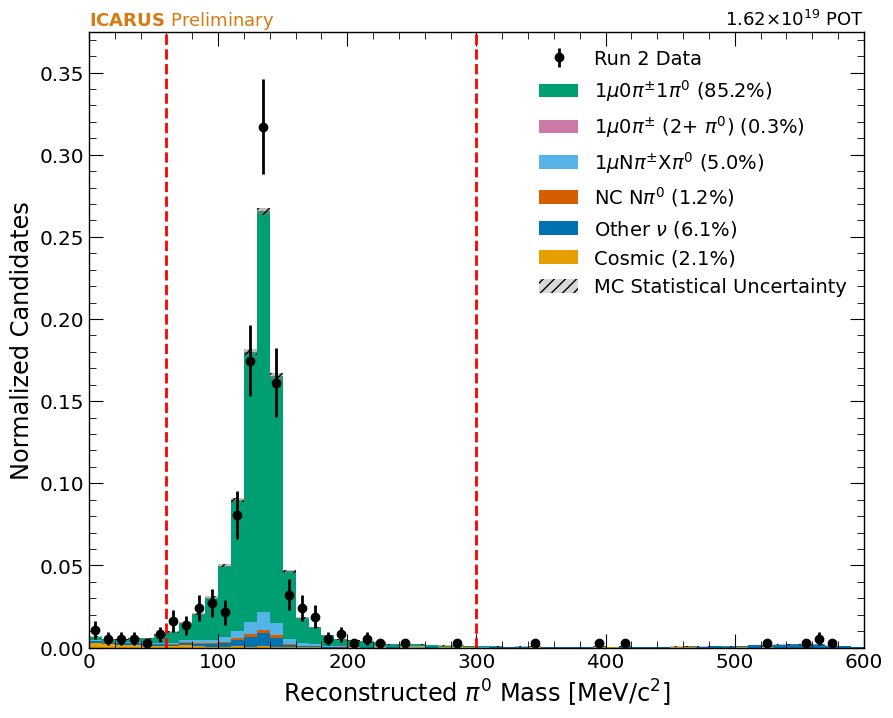

In [16]:
reduce = lambda x : [x[i] for i in histogram_mask][::-1]

# normalization
scale_sim = 1.0 if not normalize else 1.0 / np.sum(reduce(data))

fig,ax = plt.subplots(figsize=figsize)
# sim
bottom = np.zeros(len(bin_centers))
for (d,l,c) in zip(reduce(data),reduce(labels),reduce(category_colors)):
    ax.bar(bin_centers, d*scale_sim, width=bin_widths, bottom=bottom, align='center', label=l, color=c)
    bottom+=d*scale_sim

# Fitting
if fit['type'] != None:
    if fit['type'] == 'double_sided_crystal_ball':
        
        mu = np.sum(bottom * bin_centers) / np.sum(bottom)
        sigma = np.sqrt(np.sum(bottom * (bin_centers**2)) / np.sum(bottom))
        alpha_l = 1.5
        alpha_r = 1.5
        n_l = 2.3
        n_r = 2.3
        N = max(bottom)  
        initial_guess = [mu, sigma, alpha_l, alpha_r, n_l, n_r, N]
        
        func = locals()[fit['type']]
        popt, cov = curve_fit(func, bin_centers[fit['start_index']:fit['end_index']], bottom[fit['start_index']:fit['end_index']], p0=initial_guess)
        mu_fit, sigma_fit, alpha_L_fit, alpha_R_fit, n_L_fit, n_R_fit, N_fit = popt
        x_fit = np.linspace(0, 400, 1000)
        y_fit = func(x_fit, *popt)
        fit_label = ''
        fit_label = '\n'
        fit_label += r"$\bf{Double}$$\bf{\text{-}}$$\bf{Sided}$ $\bf{Crystal}$ $\bf{Ball}$ $\bf{Fit}$"
        fit_label += r" $\bf{(MC)}$"
        fit_label += '\n'
        mu_label = rf"${popt[0]:.2f}^{{+{sim_ci_upper[0] - popt[0]:.2f}}}_{{-{popt[0] - sim_ci_lower[0]:.2f}}}$"
        fit_label += f'$\\mu = ${mu_label} MeV/c$^2$\n'
        sigma_label = rf"${popt[1]:.2f}^{{+{sim_ci_upper[1] - popt[1]:.2f}}}_{{-{popt[1] - sim_ci_lower[1]:.2f}}}$"
        fit_label += f'$\\sigma = ${sigma_label} MeV/c$^2$\n'
        fit_label += '\n'
   
    ax.plot(x_fit, y_fit, color='darkmagenta', label=fit_label, zorder=100)

# data
if(show_data):
    reduce = lambda x : [x[i] for i in scatter_mask]
    for i, label in enumerate(reduce(labels)):
        scale_data = 1.0 if not normalize else 1.0 / np.sum(data[scatter_mask[i]])
        nonzero_idxs = [idx for idx,val in enumerate(data[scatter_mask[i]]) if val > 0]
        ax.errorbar(bin_centers[nonzero_idxs], scale_data*data[scatter_mask[i]][nonzero_idxs], yerr=scale_data*np.sqrt(data[scatter_mask[i]][nonzero_idxs]), fmt='o', label=label, color=category_colors[scatter_mask[i]])
        max_data_y = max(scale_data*data[scatter_mask[i]][nonzero_idxs] + scale_data*np.sqrt(data[scatter_mask[i]][nonzero_idxs]))

        if fit['type'] != None:
            
            mu = np.sum(bottom * bin_centers) / np.sum(scale_data*data[scatter_mask[i]])
            sigma = np.sqrt(np.sum(scale_data*data[scatter_mask[i]] * (bin_centers**2)) / np.sum(scale_data*data[scatter_mask[i]]))
            alpha_l = 1.5
            alpha_r = 1.5
            n_l = 2.3
            n_r = 2.3
            N = max(bottom)    
            initial_guess = [mu, sigma, alpha_l, alpha_r, n_l, n_r, N]   

            
            popt, cov = curve_fit(func, bin_centers[fit['start_index']:fit['end_index']], scale_data*data[scatter_mask[i]][fit['start_index']:fit['end_index']], p0=initial_guess)
            mu_fit, sigma_fit, alpha_L_fit, alpha_R_fit, n_L_fit, n_R_fit, N_fit = popt
            x_fit = np.linspace(0, 400, 1000)
            y_fit = func(x_fit, *popt)
            fit_label = '\n'
            fit_label += r"$\bf{Double}$$\bf{\text{-}}$$\bf{Sided}$ $\bf{Crystal}$ $\bf{Ball}$ $\bf{Fit}$"
            fit_label += r" $\bf{(Data)}$"
            fit_label += '\n'
            mu_label = rf"${popt[0]:.2f}^{{+{data_ci_upper[0] - popt[0]:.2f}}}_{{-{popt[0] - data_ci_lower[0]:.2f}}}$"
            fit_label += f'$\\mu = ${mu_label} MeV/c$^2$\n'
            sigma_label = rf"${popt[1]:.2f}^{{+{data_ci_upper[1] - popt[1]:.2f}}}_{{-{popt[1] - data_ci_lower[1]:.2f}}}$"
            fit_label += f'$\\sigma = ${sigma_label} MeV/c$^2$\n'
            #fit_label += '\n'
            ax.plot(x_fit, y_fit, color='red', label=fit_label, zorder=101)
        
reduce = lambda x : [x[i] for i in histogram_mask[::-1]]
cov = np.sum([cov for cov in cov_mats_params.values()], axis=0)
x = bin_centers
xerr = np.diff(bin_edges)/2
y = scale_sim * np.sum(reduce(data), axis=0)
scov = transform_as(cov, scale_sim if not normalize else np.sum(reduce(data), axis=0))                                                                                                                                           
yerr = np.sqrt(np.diag(scov))
draw_error_boxes(ax, x, y, xerr, yerr, facecolor='gray', edgecolor='none', alpha=0.5, hatch='///')

# LEGEND CONFIGURATION

# sim/data with uncertainties
h, l = ax.get_legend_handles_labels()

uncert_label = "MC Total Uncertainty" if assess_systematics ==  True else "MC Statistical Uncertainty"
# legend no fits
if fit['type'] == None:
    h.append(plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.3, hatch='///'))
    l.append(uncert_label)
    ax.legend(h[-2::-1]+h[-1:], l[-2::-1]+l[-1:])
else:
    h.append(plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.3, hatch='///'))
    l.append(uncert_label)
    h, l = h[-2::-1]+h[-1:], l[-2::-1]+l[-1:]
    temp_indices = [i for i in range(len(h))]
    new_indices = temp_indices[:-3] + [temp_indices[-1], temp_indices[-3], temp_indices[-2]]
    h = [h[i] for i in new_indices]
    l = [l[i] for i in new_indices]
    ax.legend(h,l)


# cut markers for pi0 mass
ax.axvline(60, linestyle="--", color="red")
ax.axvline(300, linestyle="--", color="red")

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim([bin_edges[0], bin_edges[-1]])

# Overrides for quick plotting
#ax.set_ylim([0.0, max_data_y + ax.get_ylim()[1]/15])
if _var_ylim:
    ax.set_ylim(_var_ylim)
else:
    ax.set_ylim([0, max(y) + ax.get_ylim()[1]/2])

#ax.set_ylim([0, 0.50]) # had. inv. mass
#ax.set_ylim([0, 75])

add_plot_labels(ax, onbeam_pot, vadj=0.0, ana_status=r"$\bf{ICARUS}$ Preliminary", title=str())
savestring = f'plots/{_vars[0]}'
if not show_data:
    savestring += '_sim'
if assess_systematics:
    savestring += '_syst'
plt.savefig(savestring + '.png')
plt.savefig(savestring + '.pdf', format='pdf')
plt.show()